<a href="https://colab.research.google.com/github/spegas/Dacon/blob/main/stock_price_lstm_up_down.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas matplotlib scikit-learn tensorflow yfinance

In [20]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder

In [3]:
# 주식 데이터 가져오기
ticker = '005930.KS'  # 삼성전자 종목코드 예시

In [4]:
end_date = datetime.today()
str_end_date = end_date.strftime('%Y-%m-%d')
print(" -- str_end_date -- ")
print(str_end_date)

start_date = end_date - timedelta(days=1000)

str_start_date = start_date.strftime('%Y-%m-%d')
print(" -- str_start_date -- ")
print(str_start_date)

 -- str_end_date -- 
2024-05-23
 -- str_start_date -- 
2021-08-27


In [5]:
from copy import deepcopy
fetch_stock_data = yf.download(ticker, start=str_start_date, end=str_end_date)
print(fetch_stock_data.columns)
print(fetch_stock_data.head(5))
# stock_data = fetch_stock_data[['Close', 'Volume']]

stock_data = fetch_stock_data.copy(deep=True).drop(columns=['Adj Close'])

[*********************100%%**********************]  1 of 1 completed

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2021-08-27  74300.0  75000.0  73800.0  74300.0  70375.070312  15172748
2021-08-30  75400.0  75500.0  74200.0  74600.0  70659.218750  12686999
2021-08-31  74900.0  76700.0  74300.0  76700.0  72648.289062  24630370
2021-09-01  76700.0  77100.0  75900.0  76800.0  72743.007812  16114775
2021-09-02  76800.0  76800.0  75700.0  76000.0  71985.257812  15347486


In [6]:
# 추가 데이터 (유사 종목 및 회사 회계정보)
# 유사 종목 데이터 예시
similar_ticker = '000660.KS'  # SK하이닉스 종목코드 예시

In [12]:
fetch_similar_data = yf.download(similar_ticker, start=str_start_date, end=str_end_date)
# stock_data['Similar_Close'] = fetch_similar_data['Close']

similar_stock_data = fetch_similar_data.copy(deep=True).drop(columns=['Adj Close'])

new_columns = [ str("s_") + str(columns) for columns in similar_stock_data.columns]

similar_stock_data.columns = new_columns

[*********************100%%**********************]  1 of 1 completed


In [13]:
total_stock_data = pd.concat([stock_data, similar_stock_data], axis=1)

In [14]:
# 회사 회계 정보 예시 (여기서는 임의의 데이터 사용)
# 실제로는 회사의 분기별 또는 연간 재무제표 데이터를 사용
financial_data = {
    'Date': stock_data.index,
    'Revenue': np.random.uniform(100, 500, len(stock_data)),
    'Operating_Income': np.random.uniform(10, 50, len(stock_data))
}

In [15]:
# financial_df = pd.DataFrame(financial_data)
# financial_df.set_index('Date', inplace=True)

# # 주식 데이터와 재무 데이터 병합
# ml_input_data = pd.concat([total_stock_data, financial_df], axis=1)
ml_input_data = total_stock_data.copy()

In [16]:
# 목표 변수 생성
ml_input_data['Target'] = np.where(ml_input_data['Close'].shift(-1) > ml_input_data['Close'], 'U', 'D')
ml_input_data = ml_input_data.dropna()

In [17]:
# 입력 변수와 목표 변수 분리
X = ml_input_data.drop(columns=['Target'])
y = ml_input_data['Target']

In [18]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

In [21]:
# 라벨 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, shuffle=False)

In [33]:
# 데이터셋 생성 함수
def create_dataset(data, labels, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        Y.append(labels[i + time_step])
    return np.array(X), np.array(Y)

In [34]:
# time_step -> LSTM 학습에 사용되는 날짜, 30일이면 약 한달치 데이터를 학해해서 그 다음날꺼 예측 하는 것임
# 만약, 이시간을 길게하면 X_test, Y_test데이터가 안 만들어 질 수 있고
# 이를 극복하기 위해서 yahoo에서 주식 데이터 수집 날짜 간격을 늘리거나, 학습에 사용되는 날짜 즉, time_step를 짧게 하면 됨.
time_step = 60

# my_epochs는 학습을 몇번 반복 할것인가를 의미하는 것임,
my_epochs=5

In [35]:
X_train, Y_train = create_dataset(X_train, Y_train, time_step)
X_test, Y_test = create_dataset(X_test, Y_test, time_step)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(475, 60, 10) (475,)
(74, 60, 10) (74,)


In [36]:
# LSTM 모델 입력 형식에 맞게 데이터 변형
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

print(X_train.shape)
print(X_test.shape)

(475, 60, 10)
(74, 60, 10)


In [37]:
# LSTM 모델 입력 형식에 맞게 데이터 변형
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# LSTM 모델 정의 및 학습
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 sigmoid 활성화 함수

# 옵티마이저 설정 (학습률 변경)
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=1, epochs=my_epochs)

Epoch 1/5
475/475 [==============================] - 16s 26ms/step - loss: 0.6882 - accuracy: 0.5411
Epoch 2/5
475/475 [==============================] - 13s 28ms/step - loss: 0.6853 - accuracy: 0.5621
Epoch 3/5
475/475 [==============================] - 13s 27ms/step - loss: 0.6862 - accuracy: 0.5621
Epoch 4/5
475/475 [==============================] - 13s 27ms/step - loss: 0.6907 - accuracy: 0.5558
Epoch 5/5
475/475 [==============================] - 13s 27ms/step - loss: 0.6824 - accuracy: 0.5642


In [39]:
# 테스트 데이터 예측
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)  # 0.5를 기준으로 클래스를 결정

# 예측 결과를 'U'와 'D'로 변환
predicted_labels = label_encoder.inverse_transform(predictions.flatten())

# 실제값과 예측값 시각화
actual_labels = label_encoder.inverse_transform(Y_test)

3/3 [==============================] - 0s 14ms/step


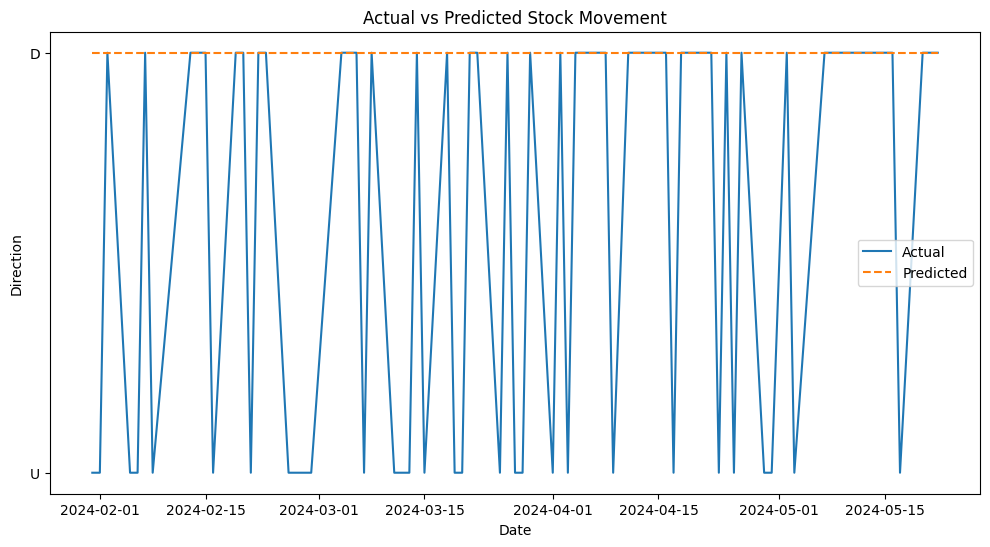

In [41]:
results = pd.DataFrame({'Date': ml_input_data.index[-len(actual_labels):], 'Actual': actual_labels, 'Predicted': predicted_labels})

# 실제값과 예측값을 시각화
plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual'], label='Actual')
plt.plot(results['Date'], results['Predicted'], label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Direction')
plt.title('Actual vs Predicted Stock Movement')
plt.legend()
plt.show()